# Perform Classification on the ADNI dataset using kNN

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import time
try:
    import cPickle as thepickle
except ImportError:
    import _pickle as thepickle
from IPython.display import display
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from scipy.interpolate import interp1d
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV

### Read the data:

Instead of reading the whole database, we read only the data that's useful to us. That is, we read only specific columns of data, and we take only the row containing the first scan for each person. 

In "ADNI Regressional Analysis.ipynb" we have done that exactly, as well as performed linear regression transformation to the imaging data, in order to remove any age, sex, and DLICV_baseline effect. 

Furthermore, in "ADNI OPNMF.ipynb" we have performed dimensionality reduction through the OPNMF method, reducing the number of the ROIs from 145 to just 18. (Hasn't been done, so this does not apply)

Additionally, in "ADNI DeepCCA initial.ipynb" we have transformed the imaging and the genetic data using Deep Canonical Correlation Analysis to dimensionally reduced, maximally linearly correlated data. 

The data is located at "./DATA/ADNI_dataset.csv"
The transformed through LR data is located at "./DATA/Linearly_Transformed_Unique_Dataset.pkl"
The further transormed (through DCCA) data is located at "./DATA/ADNI_initial_DCCA_features.pkl"

(Need to run the RA and DCCA code if data is not found)

In [2]:
# Read the original data:
data = pd.read_csv("DATA/ADNI_dataset.csv", low_memory=False) # Need the low_memory or dtypes warning
data.replace({'Sex':{'F':1, 'M':0}}, inplace=True)

# The columns that interest us are the sex and age related, the ROIs, as well as the genetic data:
columns_of_interest = ['PTID',
                       'Date',
                       'Age', 
                       'Sex',
                       'DLICV_baseline',
                       'APOE4_Alleles',
                       'APOE_Genotype',
                       'Diagnosis_nearest_2.0']
c = list(data.columns)
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]

columns_of_interest += MRI_columns + genetic_columns

# Need the dropna because some first PTIDs have no MRI
data_of_interest = data[columns_of_interest].dropna(subset=['MUSE_Volume_4', 'DLICV_baseline'])


unique = data_of_interest.drop_duplicates(subset=['PTID'], keep='first')
u = unique.dropna() # only 2 values in Diagnosis_nearest_2.0' have NaN, easier to drop them:
unique = u
unique['Diagnosis_nearest_2.0'] = unique['Diagnosis_nearest_2.0'].astype('category')
unique['Diagnosis_nearest_2.0_cat'] = unique['Diagnosis_nearest_2.0'].cat.codes
print(unique.shape)
unique.head(15)

(1567, 208)


,PTID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,MUSE_Volume_11,...,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358,Diagnosis_nearest_2.0_cat
0,002_S_0295,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,1873.124153,1586.249283,...,1,1,1,0,0,0,0,0,1,0
9,002_S_0413,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,2131.516933,1505.034469,...,0,1,1,0,1,0,0,0,0,0
24,002_S_0559,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,2366.717680,3157.732947,...,0,0,0,0,1,0,0,0,0,0
31,002_S_0619,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,5124.734093,2981.605944,...,0,0,0,1,1,0,0,0,2,1
36,002_S_0685,2006-07-06,89.561644,1,1372862.125,0.0,E3/E3,CN,2941.520445,1693.826402,...,1,1,1,0,0,0,0,0,0,0
45,002_S_0729,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,966.095170,1921.643449,...,0,0,0,1,1,0,0,0,1,2
64,002_S_0816,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,1427.160586,1604.163157,...,0,0,0,0,1,0,0,0,2,1
69,002_S_0938,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,1931.131939,1136.952611,...,0,1,1,0,1,0,0,0,0,1
74,002_S_0954,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,707.696352,2621.956978,...,2,1,1,0,1,0,0,0,1,2
81,002_S_0955,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,2681.014413,1374.257191,...,1,0,0,0,1,0,0,0,1,1


In [3]:
# Read the data transformed through the Regressional Analysis:
lr_data = pd.read_pickle("./DATA/Linearly_Transformed_Unique_Dataset.pkl")
print(lr_data.shape)
lr_data.head(15)

(1302, 208)


,PTID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,MUSE_Volume_11,...,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358,Diagnosis_nearest_2.0_cat
0,002_S_0295,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,-440.777069,-507.297168,...,1,1,1,0,0,0,0,0,1,0
9,002_S_0413,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,577.755137,-188.813792,...,0,1,1,0,1,0,0,0,0,0
24,002_S_0559,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,198.499249,1080.290951,...,0,0,0,0,1,0,0,0,0,0
31,002_S_0619,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,2623.687012,649.558822,...,0,0,0,1,1,0,0,0,2,1
45,002_S_0729,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,246.226215,628.340793,...,0,0,0,1,1,0,0,0,1,2
64,002_S_0816,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,-145.138564,-193.593195,...,0,0,0,0,1,0,0,0,2,1
69,002_S_0938,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,169.421397,-610.085153,...,0,1,1,0,1,0,0,0,0,1
74,002_S_0954,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,-81.664210,1343.833768,...,2,1,1,0,1,0,0,0,1,2
81,002_S_0955,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,1036.385233,-353.324662,...,1,0,0,0,1,0,0,0,1,1
84,002_S_1018,2006-11-29,70.658904,1,1355603.000,0.0,E3/E3,Dementia,-495.018850,486.447691,...,1,1,1,0,0,0,0,0,0,1


In [4]:
# Create a new dataset and drop the imaging and genetic data:
c = list(lr_data.columns)
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]
columns_to_drop = MRI_columns + genetic_columns
dcca_data = lr_data.drop(labels = columns_to_drop, axis=1)

# Read the data transformed through DCCA:
with open("./DATA/ADNI_initial_DCCA_features.pkl", 'rb') as f:
    dcca_transformed_data_file = pickle.load(f)
transformed_imaging_data = dcca_transformed_data_file[0]
transformed_genetic_data = dcca_transformed_data_file[1]
print("Transformed imaging data dimensions: \n" , transformed_imaging_data.shape)
print("Transformed genetic data dimensions: \n" , transformed_genetic_data.shape)

# Embed them into the new dataset:
imaging_labels = ["imaging_component_"+str(x+1) for x in range(transformed_imaging_data.shape[1])] 
genetic_labels = ["genetic_component_"+str(x+1) for x in range(transformed_genetic_data.shape[1])] 
dcca_data[genetic_labels] = transformed_genetic_data
dcca_data[imaging_labels] = transformed_imaging_data
print("DCCA Data Dimensions: \n",dcca_data.shape)
dcca_data.head(15)

Transformed imaging data dimensions: 
 (1302, 50)
Transformed genetic data dimensions: 
 (1302, 50)
DCCA Data Dimensions: 
 (1302, 109)


/opt/homebrew/Caskroom/miniconda/base/envs/DeepCCA/lib/python3.8/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


,PTID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,Diagnosis_nearest_2.0_cat,genetic_component_1,...,imaging_component_41,imaging_component_42,imaging_component_43,imaging_component_44,imaging_component_45,imaging_component_46,imaging_component_47,imaging_component_48,imaging_component_49,imaging_component_50
0,002_S_0295,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,0,-0.900052,...,0.265450,-0.588481,1.494160,0.464641,-0.464080,0.429959,-0.889877,2.429341,-1.496970,-4.961033
9,002_S_0413,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,0,0.946432,...,-0.258067,0.501793,-1.752262,-1.133469,-1.435080,2.133784,2.246922,1.358195,-1.712850,-3.594905
24,002_S_0559,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,0,0.441804,...,-0.866534,0.204544,1.261519,0.243370,-0.996479,0.513263,0.640849,3.994700,-0.652729,-5.405854
31,002_S_0619,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,1,-1.281685,...,-2.367742,-1.426929,-1.775892,0.243927,-0.938351,-1.685831,0.941371,-3.021171,-1.171651,4.267579
45,002_S_0729,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,2,0.970438,...,-1.079121,2.071898,-2.648068,2.525044,-1.129323,1.334971,4.189767,1.001328,-2.864766,-2.184807
64,002_S_0816,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,1,0.847462,...,-1.302565,0.370142,-1.022972,4.002663,-2.062786,-1.412294,0.224565,-1.582735,-1.250033,0.599805
69,002_S_0938,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,1,1.102613,...,-0.744012,0.715234,-0.583494,-0.117094,-0.079651,0.871680,-0.726903,3.892656,0.357023,-4.085205
74,002_S_0954,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,2,2.527155,...,-2.024902,-0.474762,-0.873614,1.842189,-0.073196,-2.014327,2.128241,2.425868,-0.404456,-4.454329
81,002_S_0955,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,1,0.725801,...,-0.808556,1.607881,-3.023479,1.542968,-0.623446,1.152979,4.360084,0.300277,-1.527782,-4.298677
84,002_S_1018,2006-11-29,70.658904,1,1355603.000,0.0,E3/E3,Dementia,1,0.175098,...,-1.887000,-2.865357,3.209321,1.936926,-1.822992,-0.668024,-0.510700,2.820206,1.087956,-7.384209


### Perform Classification using k Nearest Neighbors:

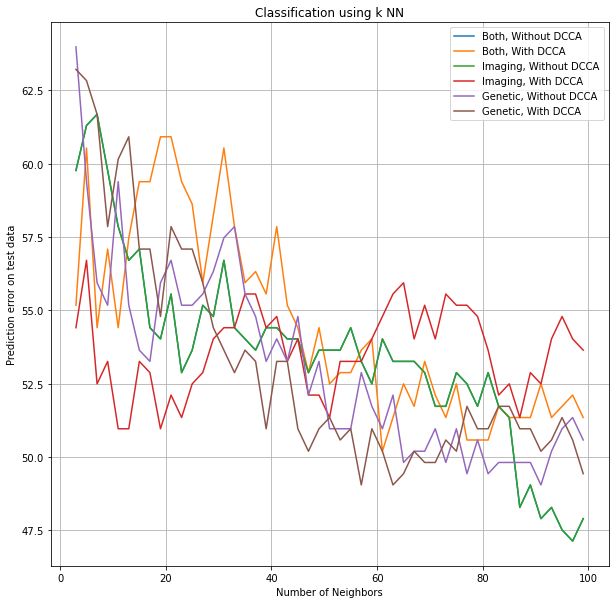

In [5]:
accs = []
accs_d = []
accs_i = []
accs_d_i = []
accs_g = []
accs_d_g = []

neighbors = [x for x in range(3,101,2)]
for nn in neighbors:
    
    knn = KNeighborsClassifier(n_neighbors=nn, n_jobs=-1)
    ############################################################################  on all data (without DCCA):
    # Get the values that interest us:
    X = lr_data[MRI_columns + genetic_columns]
    Y = lr_data["Diagnosis_nearest_2.0_cat"]
    # Perform train-test split:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train, Y_train)
    # Predict:
    acc = knn.score(X_test, Y_test)
    accs.append(100 - acc*100)
    
    knn = KNeighborsClassifier(n_neighbors=nn, n_jobs=-1)
    ############################################################################ on all data (with DCCA):
    # Get the values that interest us:
    X_d = dcca_data[genetic_labels + imaging_labels]
    Y_d = dcca_data["Diagnosis_nearest_2.0_cat"]
    # Perform train-test split:
    X_train_d, X_test_d, Y_train_d, Y_test_d = train_test_split(X_d, Y_d, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train_d, Y_train_d)
    # Predict:
    acc_d = knn.score(X_test_d, Y_test_d)
    accs_d.append(100 - acc_d*100)
    
    knn = KNeighborsClassifier(n_neighbors=nn, n_jobs=-1)   
    ############################################################################  on imaging data (without DCCA):
    # Get the values that interest us:
    X = lr_data[MRI_columns]
    Y = lr_data["Diagnosis_nearest_2.0_cat"]
    # Perform train-test split:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train, Y_train)
    # Predict:
    acc = knn.score(X_test, Y_test)
    accs_i.append(100 - acc*100)
      
    knn = KNeighborsClassifier(n_neighbors=nn, n_jobs=-1)
    ############################################################################ on imaging data (with DCCA):
    # Get the values that interest us:
    X_d = dcca_data[imaging_labels]
    Y_d = dcca_data["Diagnosis_nearest_2.0_cat"]
    # Perform train-test split:
    X_train_d, X_test_d, Y_train_d, Y_test_d = train_test_split(X_d, Y_d, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train_d, Y_train_d)
    # Predict:
    acc_d = knn.score(X_test_d, Y_test_d)
    accs_d_i.append(100 - acc_d*100)
    
    knn = KNeighborsClassifier(n_neighbors=nn, n_jobs=-1)
    ############################################################################  on genetic data (without DCCA):
    # Get the values that interest us:
    X = lr_data[genetic_columns]
    Y = lr_data["Diagnosis_nearest_2.0_cat"]
    # Perform train-test split:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train, Y_train)
    # Predict:
    acc = knn.score(X_test, Y_test)
    accs_g.append(100 - acc*100)

    knn = KNeighborsClassifier(n_neighbors=nn, n_jobs=-1)   
    ############################################################################ on genetic data (with DCCA):
    # Get the values that interest us:
    X_d = dcca_data[genetic_labels]
    Y_d = dcca_data["Diagnosis_nearest_2.0_cat"]
    # Perform train-test split:
    X_train_d, X_test_d, Y_train_d, Y_test_d = train_test_split(X_d, Y_d, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train_d, Y_train_d)
    # Predict:
    acc_d = knn.score(X_test_d, Y_test_d)
    accs_d_g.append(100 - acc_d*100)


plt.figure(figsize=(10,10))
plt.plot(neighbors, accs, label="Both, Without DCCA")
plt.plot(neighbors, accs_d, label="Both, With DCCA")
plt.plot(neighbors, accs_i, label="Imaging, Without DCCA")
plt.plot(neighbors, accs_d_i, label="Imaging, With DCCA")
plt.plot(neighbors, accs_g, label="Genetic, Without DCCA")
plt.plot(neighbors, accs_d_g, label="Genetic, With DCCA")
plt.grid()
plt.legend()
plt.title("Classification using k NN")
plt.ylabel("Prediction error on test data")
plt.xlabel("Number of Neighbors")
plt.show()

## Try with balancing & scaling:

In [8]:
# Read data:
lr_data = pd.read_pickle("./DATA/Linearly_Transformed_Unique_Dataset.pkl")

# Scale the data:
scaler = preprocessing.StandardScaler()
lr_data_scaled = scaler.fit_transform(lr_data[MRI_columns + genetic_columns])
lr_data[MRI_columns + genetic_columns] = lr_data_scaled

# Balance the data through Undersampling:
rus = RandomUnderSampler()
X = lr_data.drop('Diagnosis_nearest_2.0_cat', axis = 1)
Y = lr_data['Diagnosis_nearest_2.0_cat']
c = list(lr_data.columns)
c.remove('Diagnosis_nearest_2.0_cat')

X_res, Y_res = rus.fit_resample(X,Y)
print(Y_res.value_counts())


lr_data = pd.DataFrame(X_res,columns = c)
lr_data['Diagnosis_nearest_2.0_cat'] = Y_res
lr_data.sort_values('PTID', inplace=True,ignore_index=True)
print(lr_data.shape)
lr_data.head(10)

0    243
1    243
2    243
Name: Diagnosis_nearest_2.0_cat, dtype: int64
(729, 208)


/var/folders/c9/121x4df174j1dqk40d8dkzvw0000gn/T/ipykernel_15120/1936122480.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  lr_data['Diagnosis_nearest_2.0_cat'] = Y_res


,PTID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,MUSE_Volume_11,...,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358,Diagnosis_nearest_2.0_cat
0,002_S_0413,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,0.714620,-0.273334,...,-0.64092,1.17621,1.156407,-0.439864,0.644880,-0.440965,-0.448317,-0.445421,-0.858172,0
1,002_S_0619,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,3.924129,1.241801,...,-0.64092,-0.65345,-0.655437,2.223871,0.644880,-0.440965,-0.448317,-0.445421,2.190505,1
2,002_S_0816,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,-0.419402,-0.281971,...,-0.64092,-0.65345,-0.655437,-0.439864,0.644880,-0.440965,-0.448317,-0.445421,2.190505,1
3,002_S_0938,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,0.074056,-1.034670,...,-0.64092,1.17621,1.156407,-0.439864,0.644880,-0.440965,-0.448317,-0.445421,-0.858172,1
4,002_S_0954,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,-0.319829,2.496518,...,3.14356,1.17621,1.156407,-0.439864,0.644880,-0.440965,-0.448317,-0.445421,0.666166,2
5,002_S_0955,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,1.434086,-0.570643,...,1.25132,-0.65345,-0.655437,-0.439864,0.644880,-0.440965,-0.448317,-0.445421,0.666166,1
6,002_S_1018,2006-11-29,70.658904,1,1355603.000,0.0,E3/E3,Dementia,-0.968269,0.947021,...,1.25132,1.17621,1.156407,-0.439864,-0.901407,-0.440965,-0.448317,-0.445421,-0.858172,1
7,002_S_1070,2006-11-28,73.564384,0,1550701.375,0.0,E3/E3,MCI,0.197327,0.999431,...,-0.64092,-0.65345,-0.655437,-0.439864,-0.901407,-0.440965,-0.448317,-0.445421,-0.858172,2
8,002_S_1268,2007-02-14,82.642466,0,1435189.875,1.0,E3/E4,MCI,0.134760,-0.828707,...,-0.64092,-0.65345,-0.655437,-0.439864,0.644880,1.981551,1.953778,1.981097,0.666166,2
9,002_S_4219,2011-09-14,79.364384,1,1399624.875,0.0,E3/E3,MCI,-1.004939,0.680015,...,-0.64092,-0.65345,-0.655437,-0.439864,-0.901407,-0.440965,-0.448317,-0.445421,-0.858172,2


In [9]:
# Scale the data:
scaler = preprocessing.StandardScaler()
dcca_data_scaled = scaler.fit_transform(dcca_data[imaging_labels + genetic_labels])
dcca_data[imaging_labels + genetic_labels] = dcca_data_scaled

# Balance the data through Undersampling - Use the same indexes as the LR Data:
dcca_data = dcca_data.loc[dcca_data['PTID'].isin(lr_data['PTID'])]

print(dcca_data.shape)
dcca_data.head(10)

(729, 109)


,PTID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,Diagnosis_nearest_2.0_cat,genetic_component_1,...,imaging_component_41,imaging_component_42,imaging_component_43,imaging_component_44,imaging_component_45,imaging_component_46,imaging_component_47,imaging_component_48,imaging_component_49,imaging_component_50
9,002_S_0413,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,0,0.571964,...,-0.179742,0.313501,-0.532730,-0.584095,-1.087212,1.405349,0.937182,0.671208,-1.014617,-1.029699
31,002_S_0619,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,1,-0.723297,...,-1.537487,-0.838057,-0.539897,0.131157,-0.711300,-1.082178,0.389522,-1.487128,-0.695738,1.179437
64,002_S_0816,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,1,0.514430,...,-0.851960,0.234898,-0.311515,2.082986,-1.562243,-0.904037,0.088832,-0.778207,-0.741921,0.148896
69,002_S_0938,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,1,0.662756,...,-0.492486,0.440937,-0.178209,-0.056313,-0.061459,0.583402,-0.310295,1.920298,0.204968,-1.167459
74,002_S_0954,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,2,1.490879,...,-1.316842,-0.269559,-0.266211,0.961099,-0.056573,-1.296111,0.887397,1.197403,-0.243701,-1.271172
81,002_S_0955,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,1,0.443706,...,-0.534026,0.973899,-0.918326,0.805721,-0.472989,0.766599,1.823622,0.149822,-0.905573,-1.227439
84,002_S_1018,2006-11-29,70.658904,1,1355603.000,0.0,E3/E3,Dementia,1,0.123568,...,-1.228091,-1.696881,0.972259,1.010294,-1.380774,-0.419331,-0.219600,1.391749,0.635639,-2.094386
90,002_S_1070,2006-11-28,73.564384,0,1550701.375,0.0,E3/E3,MCI,2,-0.109057,...,-0.899064,0.506414,-0.012505,-0.128085,-0.377317,1.031096,0.786820,1.000054,0.353096,-1.901802
127,002_S_1268,2007-02-14,82.642466,0,1435189.875,1.0,E3/E4,MCI,2,-0.861924,...,-1.001734,1.242855,-0.775585,1.070470,-0.671425,1.526120,1.587565,0.428432,-1.216751,-1.114267
180,002_S_4219,2011-09-14,79.364384,1,1399624.875,0.0,E3/E3,MCI,2,0.549770,...,-0.055041,-0.824645,0.562729,-1.995806,1.527614,0.784696,-1.073783,-0.829082,1.108482,0.651367
